In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms

Using only the final FC layer of the resnet50, we acheive the accuracy of about 80%. So we have fine tuned more layers (from Conve5_x to the final layer) and the accuracy became 90%

Training resnet18 from scratch resulted in the accuracy of about 90%

Trainig resnet18 using the trained resnet50 model resulted in a better accuracy. In the original cost function, changing the values of $T$ and $\alpha$, we reach to the accuracy of about 92~93%. But dropping the $T^2$ in the cost function, we acheived the accuracy of 95%

In [ ]:
# Reading DATA
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

Transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize(224), normalize])

training_data = datasets.CIFAR10(
    root="data", 
    train=True,
    download=False,
    transform=Transforms
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=False,
    transform=Transforms
)

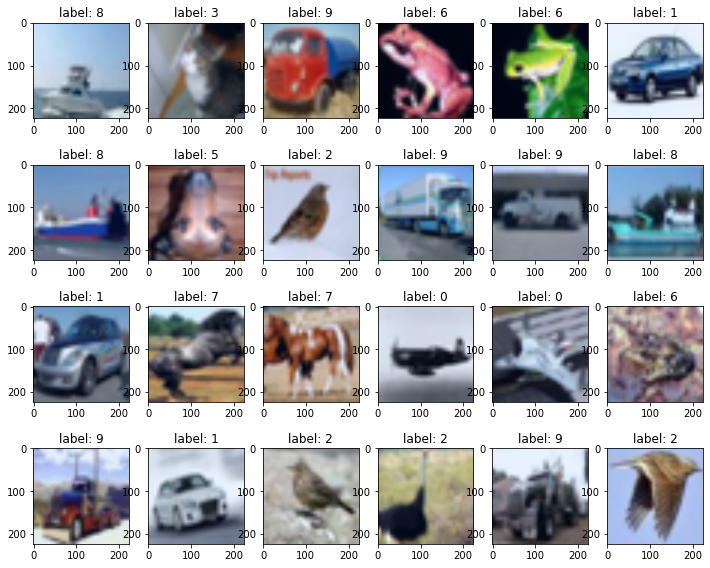

In [3]:
# Showing some image data
plt.figure(figsize= (12, 10))
for i in range(24):
    img, label = training_data[i+100]
    img = img.permute(1, 2, 0)
    img = (img - torch.min(img))/(torch.max(img) - torch.min(img))
    plt.subplot(4, 6, i + 1)
    plt.imshow(img), plt.title(f'label: {label}')

In [4]:
batch_size = 64
train_dataloader = data_utils.DataLoader(training_data, batch_size = batch_size, shuffle = True)
test_dataloader = data_utils.DataLoader(test_data, batch_size = batch_size, shuffle = True)
print(len(training_data), len(test_data), len(train_dataloader), len(test_dataloader))

50000 10000 782 157


In [17]:
from torchvision import models
resnet18 = models.resnet18(pretrained=True)
resnet50 = models.resnet50(pretrained=True)

In [8]:
# Constructing appropriate models from the pretrained model (Changing the final FC dimension and adding dropout) 
from torch import nn
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available else 'cpu'
resnet18 = resnet18.to(device)
resnet50 = resnet50.to(device)
#summary(resnet50, (3, 64, 64))
new_resnet50 = nn.Sequential(*list(resnet50.children())[:-1], nn.Flatten(),
                             nn.Dropout(p = 0.5),
                            #nn.Linear(in_features= 2048, out_features= 512), nn.ReLU(),
                            nn.Linear(in_features= 2048, out_features= 10))
new_resnet18 = nn.Sequential(*list(resnet18.children())[:-1], nn.Flatten(),
                            nn.Dropout(p = 0.4),
                            nn.Linear(in_features= 512, out_features= 10))
new_resnet50 = new_resnet50.to(device)
new_resnet18 = new_resnet18.to(device)
#summary(new_resnet50, (3, 64, 64))
#print(new_resnet50)

In [9]:
params = new_resnet50.named_parameters()
for i, (name, par) in enumerate(params):
    print(i, '\t', name, '\t\t', par.size())

0 	 0.weight 		 torch.Size([64, 3, 7, 7])
1 	 1.weight 		 torch.Size([64])
2 	 1.bias 		 torch.Size([64])
3 	 4.0.conv1.weight 		 torch.Size([64, 64, 1, 1])
4 	 4.0.bn1.weight 		 torch.Size([64])
5 	 4.0.bn1.bias 		 torch.Size([64])
6 	 4.0.conv2.weight 		 torch.Size([64, 64, 3, 3])
7 	 4.0.bn2.weight 		 torch.Size([64])
8 	 4.0.bn2.bias 		 torch.Size([64])
9 	 4.0.conv3.weight 		 torch.Size([256, 64, 1, 1])
10 	 4.0.bn3.weight 		 torch.Size([256])
11 	 4.0.bn3.bias 		 torch.Size([256])
12 	 4.0.downsample.0.weight 		 torch.Size([256, 64, 1, 1])
13 	 4.0.downsample.1.weight 		 torch.Size([256])
14 	 4.0.downsample.1.bias 		 torch.Size([256])
15 	 4.1.conv1.weight 		 torch.Size([64, 256, 1, 1])
16 	 4.1.bn1.weight 		 torch.Size([64])
17 	 4.1.bn1.bias 		 torch.Size([64])
18 	 4.1.conv2.weight 		 torch.Size([64, 64, 3, 3])
19 	 4.1.bn2.weight 		 torch.Size([64])
20 	 4.1.bn2.bias 		 torch.Size([64])
21 	 4.1.conv3.weight 		 torch.Size([256, 64, 1, 1])
22 	 4.1.bn3.weight 		 torch.Size([2

In [15]:
# Loss function for the disstiled model
def Loss_Func(logits50, logits18, y_true, T, alpha):
    Len = len(y_true)
    soft50 = torch.softmax(logits50/T, dim = 1)
    soft18 = torch.softmax(logits18/T, dim = 1)
    Cross_dis = soft50*torch.log(soft18)
    L1 = -torch.sum(Cross_dis)/Len
    soft_class = torch.softmax(logits18, dim = 1)
    Cross_class = torch.log(soft_class[np.arange(Len), y_true])
    L2 = -torch.sum(Cross_class)/Len
    return alpha*(1**2)*L1 + (1-alpha)*L2

In [13]:
# Set parameters for training and freeze the other ones. Optimizer setting.
params = new_resnet50.parameters()
for i, par in enumerate(params):
    if i <= 140:
        #pass
        par.requires_grad = False;

optimizer_res50 = torch.optim.Adam(new_resnet50.parameters(), lr = 1e-4, weight_decay = 1e-3);
optimizer_res18 = torch.optim.Adam(new_resnet18.parameters(), lr = 1e-4);
loss_func50 = nn.CrossEntropyLoss()

In [12]:
# Train and test loop 
def train_loop1(Model, Optimizer, Loss_Func, dataloader, kep):
    LD = len(dataloader.dataset)
    for i, (X, y) in enumerate(dataloader):
        y.squeeze_()
        y = y.to(torch.long)
        X, y = X.to(device), y.to(device)
        ypred = Model(X)
        loss = Loss_Func(ypred, y)
        Optimizer.zero_grad()
        loss.backward()
        Optimizer.step()
        if i % 100 == 0:
            print(f'loss = {loss.item():5f}     [{i*batch_size:5}\{LD:5}]')

def train_loop2(Optimizer, dataloader, kep):
    LD = len(dataloader.dataset)
    for i, (X, y) in enumerate(dataloader):
        y.squeeze_()
        y = y.to(torch.long)
        X, y = X.to(device), y.to(device)
        logits50 = new_resnet50(X)
        logits18 = new_resnet18(X)
        loss = Loss_Func(logits50, logits18, y, 3, 0.5)
        Optimizer.zero_grad()
        loss.backward()
        Optimizer.step()
        if i % 100 == 0:
            print(f'loss = {loss.item():5f}     [{i*batch_size:5}\{LD:5}]')
def test_loop(Model, loss_func, dataloader, kep):
    LD = len(dataloader.dataset)
    LB = len(dataloader)
    loss = 0
    Accu = 0
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y.squeeze_()
        y = y.to(torch.long)
        with torch.no_grad():
            ypred = Model(X)
            loss += loss_func(ypred, y)
            Accu += (torch.argmax(ypred, dim = 1)==y).type(torch.float).sum().item()
    print(f'Test/Val Loss = {loss.item()/LB:5f}  ,  Accuracy = {100*Accu/LD:2f}%')

In [14]:
# Fine tuning the resnet50 
epoch50 = 5
for k in range(epoch50):
    print(f'\nEpoch: {k}-----------------------------------------')
    new_resnet50.train()
    train_loop1(new_resnet50, optimizer_res50, loss_func50, train_dataloader, k)
    new_resnet50.eval()
    test_loop(new_resnet50, loss_func50, test_dataloader, k)
print('Done!')


Epoch: 0-----------------------------------------
loss = 2.433113     [    0\50000]
loss = 0.513363     [ 6400\50000]
loss = 0.366706     [12800\50000]
loss = 0.395342     [19200\50000]
loss = 0.629940     [25600\50000]
loss = 0.279612     [32000\50000]
loss = 0.285493     [38400\50000]
loss = 0.443967     [44800\50000]
Test/Val Loss = 0.310452  ,  Accuracy = 89.560000%

Epoch: 1-----------------------------------------
loss = 0.290226     [    0\50000]
loss = 0.174934     [ 6400\50000]
loss = 0.211604     [12800\50000]
loss = 0.244150     [19200\50000]
loss = 0.337330     [25600\50000]
loss = 0.244184     [32000\50000]
loss = 0.123270     [38400\50000]
loss = 0.204342     [44800\50000]
Test/Val Loss = 0.302973  ,  Accuracy = 90.050000%

Epoch: 2-----------------------------------------
loss = 0.138647     [    0\50000]
loss = 0.044084     [ 6400\50000]
loss = 0.153209     [12800\50000]
loss = 0.060309     [19200\50000]
loss = 0.152229     [25600\50000]
loss = 0.050887     [32000\5000

In [36]:
#Training resnet18 from scratch
epoch50 = 6
for k in range(epoch50):
    print(f'\nEpoch: {k}-----------------------------------------')
    new_resnet18.train()
    train_loop1(new_resnet18, optimizer_res18, loss_func50, train_dataloader, k)
    new_resnet18.eval()
    test_loop(new_resnet18, loss_func50, test_dataloader, k)
print('Done!')


Epoch: 0-----------------------------------------
loss = 2.772479     [    0\50000]
loss = 0.397647     [ 3200\50000]
loss = 0.453276     [ 6400\50000]
loss = 0.312339     [ 9600\50000]
loss = 0.336240     [12800\50000]
loss = 0.356467     [16000\50000]
loss = 0.174214     [19200\50000]
loss = 0.256129     [22400\50000]
loss = 0.346227     [25600\50000]
loss = 0.254139     [28800\50000]
loss = 0.235685     [32000\50000]
loss = 0.334455     [35200\50000]
loss = 0.345882     [38400\50000]
loss = 0.300673     [41600\50000]
loss = 0.189006     [44800\50000]
loss = 0.145032     [48000\50000]
Test/Val Loss = 0.234522  ,  Accuracy = 91.930000%

Epoch: 1-----------------------------------------
loss = 0.202269     [    0\50000]
loss = 0.153258     [ 3200\50000]
loss = 0.146386     [ 6400\50000]
loss = 0.068887     [ 9600\50000]
loss = 0.220635     [12800\50000]
loss = 0.057922     [16000\50000]
loss = 0.071573     [19200\50000]
loss = 0.102496     [22400\50000]
loss = 0.071474     [25600\5000

KeyboardInterrupt: 

In [16]:
# Train The disstiled model
epoch1850 = 6
new_resnet50.eval()
for k in range(epoch1850):
    print(f'\nEpoch: {k}-----------------------------------------')
    new_resnet18.train()
    train_loop2(optimizer_res18, train_dataloader, k)
    new_resnet18.eval()
    test_loop(new_resnet18, loss_func50, test_dataloader, k)
print('Done!')


Epoch: 0-----------------------------------------
loss = 2.623072     [    0\50000]
loss = 0.877812     [ 6400\50000]
loss = 0.903108     [12800\50000]
loss = 0.753562     [19200\50000]
loss = 0.903207     [25600\50000]
loss = 0.651523     [32000\50000]
loss = 0.753896     [38400\50000]
loss = 0.819762     [44800\50000]
Test/Val Loss = 0.215044  ,  Accuracy = 92.660000%

Epoch: 1-----------------------------------------
loss = 0.686223     [    0\50000]
loss = 0.547339     [ 6400\50000]
loss = 0.604750     [12800\50000]
loss = 0.810652     [19200\50000]
loss = 0.698102     [25600\50000]
loss = 0.654253     [32000\50000]
loss = 0.595249     [38400\50000]
loss = 0.693730     [44800\50000]
Test/Val Loss = 0.168185  ,  Accuracy = 94.440000%

Epoch: 2-----------------------------------------
loss = 0.661258     [    0\50000]
loss = 0.612143     [ 6400\50000]
loss = 0.598506     [12800\50000]
loss = 0.632259     [19200\50000]
loss = 0.673411     [25600\50000]
loss = 0.619105     [32000\5000